---
# <div align="center">**BIG TEST**</div>  
---  

<br>

---
# **ALL UNTIL CHECKPOINT BEST MODEL**
---  

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, TargetEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score

import warnings

from lightgbm import LGBMRegressor
from matplotlib.offsetbox import AnnotationBbox, TextArea
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import randint, uniform
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split

from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)
from mapie.regression import MapieQuantileRegressor, MapieRegressor
from mapie.subsample import Subsample

In [2]:
pd.set_option('display.max_columns', None)               # Hiển thị đầy đủ bảng với thanh trượt ngang
pd.set_option('display.float_format', '{:,.4f}'.format)  # Làm tròn số hiển thị ở dạng 4 thập phân cho gọn

In [3]:
# Excel gốc bị trống dòng đầu tiên, lấy dòng 2 và 3 làm header
data_raw = pd.read_excel("D:/FOX AI/Project Info/KPI/KPI 2024.xlsx", header=[1,2])

In [4]:
# Tạo cột mới bao gồm các header muốn thay - dạng list (Đối chiếu với file excel cho dễ nhìn)
new_header = ['Tháng', 'CIF CBNV', 'Họ Tên', 
              'Mã ĐVKD', 'Khu vực', 'Đơn vị', 'Chức danh', 'Mã chức danh',     
              'Ngày vào làm việc', 'Giới tính', 'Năm sinh',                   
              'Book Huy động', 'Book Cho vay', 'Net Huy động', 'Net Cho vay',
              'Điểm Book TỔNG HĐ chưa chặn', 'Điểm Book HĐ KỲ HẠN chưa chặn', 'Điểm Book HĐ CASA chưa chặn', 'Điểm Book CV chưa chặn',
              'Điểm Net HĐ', 'Điểm Net CV', 
              'SL KH',
              'KPI_CN Book Value', 'KPI_CN Net Value', 'KPI_CN Điểm DV', 'KPI_CN CLTD/DV',
              'KPI_BP Book Value', 'KPI_BP Net Value', 'KPI_BP Điểm DV', 'KPI_BP CLTD/DV',
              'Tổng điểm CN', 'Tổng điểm BP', 
              'Điểm KH CN', 'Điểm KH BP', 
              'Tỷ trọng KPI_CN', 'Tỷ trọng KPI_BP',
              'Điểm Cộng/Trừ CN', 
              '% KPI_CN', '% KPI_BP', '% KPI cuối cùng', 
              'Thu nhập Gross'
             ]

# Ghi đè cột Header mới đủ 41 biến thay cho Header 1 và 2 MultiIndex, tạo thành dataframe 
data_raw.columns = new_header

# Đổi tên để lưu trữ
df_renamed = data_raw

# # Kiểm tra 
# display(df_renamed.info())

In [5]:
# # Kiểm tra 2
# display(df_renamed.head(3))

---
# <div align="center">**TIỀN XỬ LÍ DỮ LIỆU**</div>   
---

In [6]:
"""
0. Tháng                          Thời điểm dòng dữ liệu được ghi nhận vào hệ thống 
1. CIF CBNV                       Mã ID độc lập cho từng người, dùng để truy vấn nếu cần
2. Họ Tên
3. Mã ĐVKD             
4. Khu vực             
5. Đơn vị             
6. Chức danh           
7. Mã chức danh
8. Ngày vào làm việc
9. Giới tính
10. Năm sinh
11. Book Huy Động                 Tổng số tiền huy động được từ khách hàng     (tiền gửi, tiết kiệm, đầu tư)       >> Hiệu suất Thu hút vốn
12. Book Cho Vay                  Tổng số tiền đã giải ngân cho khách hàng vay                                     >> Hiệu suất Cho vay
13. Net Huy Động Vốn              = Book Huy Động Vốn - Số tiền khách rút ra   (Mức tăng trưởng của HĐV)           >> Hiệu suất thu hút tiền gừi
14. Net Cho Vay                   = Book Cho Vay - Số tiền khách trả nợ        (Mức tăng trưởng của Dư nợ cho vay) >> Hiệu suất tín dụng
15. Điểm Book Tổng HĐ chưa chặn   = f0(Book HĐ kỳ hạn, HĐ CASA, HĐ khác...)    (Cách tính tùy theo ngân hàng, hàm đã bị ẩn đi
16. Điểm Book HĐ kỳ hạn chưa chặn = f1(Book HĐ kỳ hạn)                          Cách tính tương tự, chỉ khác hàm: chia mức chuẩn, nhân hệ số,....) 
17. Điểm Book HĐ CASA chưa chặn   = f2(Book HĐ CASA)                                         
18. Điểm Book CV chưa chặn        = f3(Book CV)
19. Điểm Net HĐ                   = f4(Net HĐ)
20. Điểm Net CV                   = f5(Net CV)
21. SL KH
22. KPI_CN Book Value             = g0(Book HĐ, Book CV)                        Vẫn tương tự, hàm đã bị ẩn đi:
23. KPI_CN Net Value              = g1(Net HĐ, Net Value)                                     Thêm chặn, thay trọng số,... 
24. KPI_CN Điểm DV                Điểm Dư Vốn /// Điểm Dịch vụ ???????????                                   
25. KPI_CN CLTD/DV                Cho Lãi Tín Dụng / DV
26. KPI_BP Book Value                                                           Vẫn tương tự, hàm khác nữa bị ẩn đi:
27. KPI_BP Net Value                                                                          Chia cho tổng nào đó của bộ phận, thay trọng số,...    
28. KPI_BP Điểm DV                
29. KPI_BP CLTD/DV                       
30. Tổng điểm CN                  = SUM(22 23 24 25)
31. Tổng điểm BP                  = SUM(26 27 28 29)      
32. Điểm KH CN                    Điểm Kế hoạch Cá nhân
33. Điểm KH BP                    Điểm Kế hoạch Bộ phận
34. Tỷ trọng KPI_CN                    Tỷ trọng cột 34 35 để nhân với cột 37 38 ra cột 39        
35. Tỷ trọng KPI_BP                    Ví dụ: GDV tỷ trọng 1 - 0; Càng cấp cao như GĐ, KSV thì tỷ trọng 0.2 - 0.8 (chính sách ngân hàng tùy tháng)
36. Điểm Cộng/Trừ CN              Cộng vào cột 30 ???
37. % KPI_CN                      = 30 / 32
38. % KPI_BP                      = 31 / 33 
39. % KPI cuối cùng               = 30 * 37 + 35 * 38
40. Thu nhập Gross                Thu nhập trước khi trừ đi các khoản chi phí, thuế, bảo hiểm, v.v khác
"""

'\n0. Tháng                          Thời điểm dòng dữ liệu được ghi nhận vào hệ thống \n1. CIF CBNV                       Mã ID độc lập cho từng người, dùng để truy vấn nếu cần\n2. Họ Tên\n3. Mã ĐVKD             \n4. Khu vực             \n5. Đơn vị             \n6. Chức danh           \n7. Mã chức danh\n8. Ngày vào làm việc\n9. Giới tính\n10. Năm sinh\n11. Book Huy Động                 Tổng số tiền huy động được từ khách hàng     (tiền gửi, tiết kiệm, đầu tư)       >> Hiệu suất Thu hút vốn\n12. Book Cho Vay                  Tổng số tiền đã giải ngân cho khách hàng vay                                     >> Hiệu suất Cho vay\n13. Net Huy Động Vốn              = Book Huy Động Vốn - Số tiền khách rút ra   (Mức tăng trưởng của HĐV)           >> Hiệu suất thu hút tiền gừi\n14. Net Cho Vay                   = Book Cho Vay - Số tiền khách trả nợ        (Mức tăng trưởng của Dư nợ cho vay) >> Hiệu suất tín dụng\n15. Điểm Book Tổng HĐ chưa chặn   = f0(Book HĐ kỳ hạn, HĐ CASA, HĐ khác...)    (Cá

In [7]:
# Tạo bản sao dataframe gọn, tránh ghi đè
df = df_renamed.copy()

# Xóa
df.drop(columns=['CIF CBNV', 'Họ Tên'], inplace=True)

# Xóa biến đỡ phải chuẩn hóa
df.drop(columns=['Tháng', 'Năm sinh', 'Ngày vào làm việc', 'Giới tính'], inplace=True)

# Xóa biến đỡ phải chuẩn hóa 
df.drop(columns=['Mã ĐVKD', 'Khu vực', 'Đơn vị', 'Chức danh', 'Mã chức danh'], inplace=True)

---
## **MA TRẬN TƯƠNG QUAN GỐC**

In [8]:
# Ma trận tương quan ban đầu
# df_numeric = df.select_dtypes(include=[np.number])
# corr_matrix = df_numeric.corr()
# plt.figure(figsize=(16,12))
# sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
# plt.title('Correlation Matrix')
# plt.show()

In [9]:
# Xóa các biến tương quan quá cao > 0.9
df.drop(columns=['Điểm Book TỔNG HĐ chưa chặn', 'Điểm Book HĐ KỲ HẠN chưa chặn', 'Điểm Book HĐ CASA chưa chặn', 
                 'Điểm Book CV chưa chặn',             
                 'Điểm Net HĐ',                         
                 'Điểm Net CV',                        
                 'KPI_CN Book Value',                   
                 'KPI_CN Net Value',   # Giữ lại 4 cột gốc 'Book Huy động', 'Book cho vay', ' Net Huy động', 'Net Cho vay'
                 'Tỷ trọng KPI_BP'     # Giữ lại 1 cột gốc 'Tỷ trọng KPI_CN'
                ], inplace=True)

# Xóa các biến không tồn tại khi triển khai
df.drop(columns=['Tổng điểm CN', 'Tổng điểm BP', 
                 '% KPI_CN', '% KPI_BP', 
                 'Thu nhập Gross'
                ], inplace=True)

# Xóa biến thiếu ý nghĩa - khoảng 90% giá trị = 0
df.drop(columns=['Điểm Cộng/Trừ CN'], inplace=True)

---
## **KIỂM TRA TOÀN BỘ**
- **MA TRẬN TƯƠNG QUAN**
- **PHÂN PHỐI**
- **THỐNG KÊ MÔ TẢ**

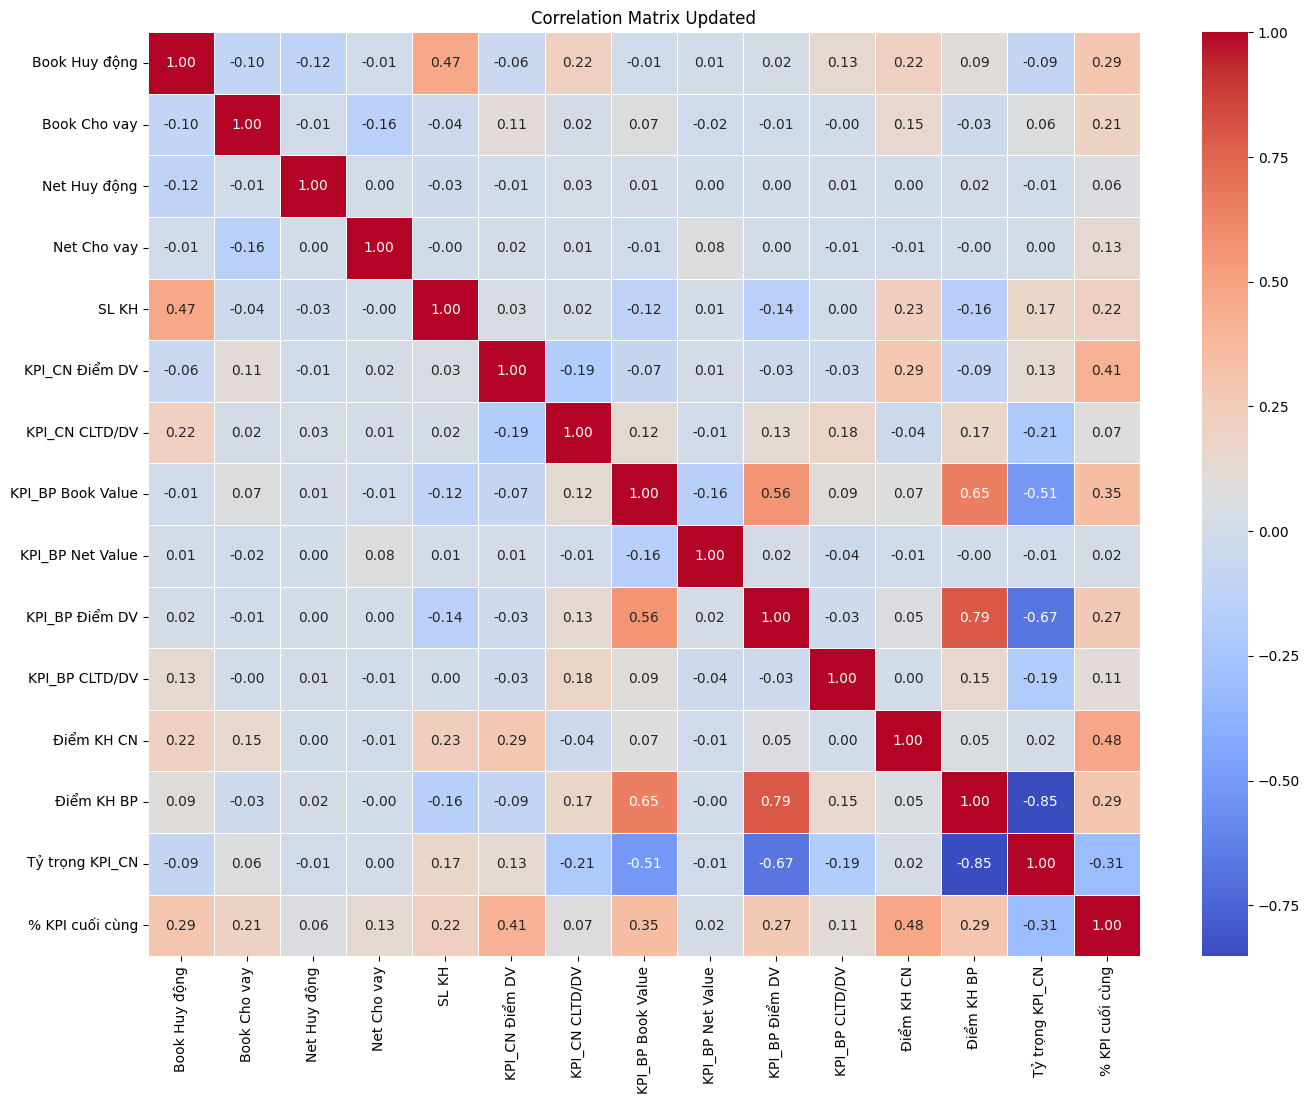

In [10]:
# Ma trận tương quan 2
df_numeric_2 = df.select_dtypes(include=[np.number])
corr_matrix_2 = df_numeric_2.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix_2, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Updated')
plt.show()

In [11]:
cols_to_keep = [
    "Book Huy động",       
    "Book Cho vay",
    "Net Huy động",
    "Net Cho vay",
    "SL KH",
    "KPI_CN Điểm DV",   # Comment để xóa nhanh các cột và thử nghiệm
    "KPI_CN CLTD/DV",
    "KPI_BP Book Value",
    "KPI_BP Net Value",
    "KPI_BP Điểm DV",
    "KPI_BP CLTD/DV",
    "Điểm KH CN",
    "Điểm KH BP",
    "Tỷ trọng KPI_CN",
    "% KPI cuối cùng",  # Target
]

# Tạo dataframe mới từ các cột đã chọn
df1 = df[cols_to_keep].copy()

In [12]:
# 1. Tách X, y
X = df1.drop(columns=["% KPI cuối cùng"])
y = df1["% KPI cuối cùng"]

# 2. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit mô hình XGB
model_1 = XGBRegressor(
    colsample_bytree=0.8,
    learning_rate=0.07,
    max_depth=7,
    n_estimators=250,
    subsample=0.8,
    random_state=42,
    verbosity=0
)
model_1.fit(X_train, y_train)
y_pred_model_1 = model_1.predict(X_test)

# Fit mô hình LGBM với quantile
model_2 = LGBMRegressor(
    objective="quantile",
    alpha=0.5,
    learning_rate=0.15,
    n_estimators=250,
    max_depth=7,
    min_child_samples=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)
model_2.fit(X_train, y_train)
y_pred_model_2 = model_2.predict(X_test)

# Tạo bảng kết quả
results = pd.DataFrame({
    "Model": ["Model 1", "Model 2"],
    "R² Test": [
        r2_score(y_test, y_pred_model_1),
        r2_score(y_test, y_pred_model_2),
    ],
    "MAE Test": [
        mean_absolute_error(y_test, y_pred_model_1),
        mean_absolute_error(y_test, y_pred_model_2),
    ],
    "RMSE Test": [
        root_mean_squared_error(y_test, y_pred_model_1),
        root_mean_squared_error(y_test, y_pred_model_2),
    ]
})
results

,Model,R² Test,MAE Test,RMSE Test
0,Model 1,0.9719,0.0342,0.0676
1,Model 2,0.9605,0.0408,0.0801


In [13]:
def sort_y_values(y_test, y_pred, y_pis):
    """
    Sorting the dataset in order to make plots using the fill_between function.
    """
    indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[indices]
    y_pred_sorted = y_pred[indices]
    y_lower_bound = y_pis[:, 0, 0][indices]
    y_upper_bound = y_pis[:, 1, 0][indices]
    return y_test_sorted, y_pred_sorted, y_lower_bound, y_upper_bound


def plot_prediction_intervals(
    title,
    axs,
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    coverage,
    width,
    num_plots_idx
):
    """
    Plot of the prediction intervals for each different conformal
    method.
    """
    axs.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axs.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    lower_bound_ = np.take(lower_bound, num_plots_idx)
    y_pred_sorted_ = np.take(y_pred_sorted, num_plots_idx)
    y_test_sorted_ = np.take(y_test_sorted, num_plots_idx)

    error = y_pred_sorted_-lower_bound_

    warning1 = y_test_sorted_ > y_pred_sorted_+error
    warning2 = y_test_sorted_ < y_pred_sorted_-error
    warnings = warning1 + warning2
    axs.errorbar(
        y_test_sorted_[~warnings],
        y_pred_sorted_[~warnings],
        yerr=np.abs(error[~warnings]),
        capsize=5, marker="o", elinewidth=2, linewidth=0,
        label="Inside prediction interval"
        )
    axs.errorbar(
        y_test_sorted_[warnings],
        y_pred_sorted_[warnings],
        yerr=np.abs(error[warnings]),
        capsize=5, marker="o", elinewidth=2, linewidth=0, color="red",
        label="Outside prediction interval"
        )
    axs.scatter(
        y_test_sorted_[warnings],
        y_test_sorted_[warnings],
        marker="*", color="green",
        label="True value"
    )
    axs.set_xlabel("TRUE")
    axs.set_ylabel("PREDICT")
    ab = AnnotationBbox(
        TextArea(
            f"Coverage: {np.round(coverage, round_to)}\n"
            + f"Interval width: {np.round(width, round_to)}"
        ),
        xy=(np.min(y_test_sorted_)*3, np.max(y_pred_sorted_+error)*0.95),
        )
    lims = [
        np.min([axs.get_xlim(), axs.get_ylim()]),  # min of both axes
        np.max([axs.get_xlim(), axs.get_ylim()]),  # max of both axes
    ]
    axs.plot(lims, lims, '--', alpha=0.75, color="black", label="x=y")
    axs.add_artist(ab)
    axs.set_title(title, fontweight='bold')

---

In [14]:
random_state = 42
alpha_test_for_all_model = 0.05
estimator = model_2

---

In [15]:
STRATEGIES = {
    "naive": {"method": "naive"},
    "cv_plus": {"method": "plus", "cv": 10},
    "jackknife_plus_ab": {"method": "plus", "cv": Subsample(n_resamplings=50)},
    "cqr": {"method": "quantile", "cv": "split", "alpha": alpha_test_for_all_model},
}
y_pred, y_pis = {}, {}
y_test_sorted, y_pred_sorted, lower_bound, upper_bound = {}, {}, {}, {}
coverage, width = {}, {}
for strategy, params in STRATEGIES.items():
    if strategy == "cqr":
        mapie = MapieQuantileRegressor(
            estimator, 
            **params
        )
        mapie.fit(
            X_train,
            y_train,
            calib_size=0.3,
            random_state=random_state
        )
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test)
    else:
        mapie = MapieRegressor(
            estimator,
            test_size=0.3,
            random_state=random_state,
            **params
        )
        mapie.fit(
            X_train,
            y_train
        )
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test, alpha=alpha_test_for_all_model)
    (
        y_test_sorted[strategy],
        y_pred_sorted[strategy],
        lower_bound[strategy],
        upper_bound[strategy]
    ) = sort_y_values(y_test, y_pred[strategy], y_pis[strategy])
    coverage[strategy] = regression_coverage_score(
        y_test,
        y_pis[strategy][:, 0, 0],
        y_pis[strategy][:, 1, 0]
        )
    width[strategy] = regression_mean_width_score(
        y_pis[strategy][:, 0, 0],
        y_pis[strategy][:, 1, 0]
        )

INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.


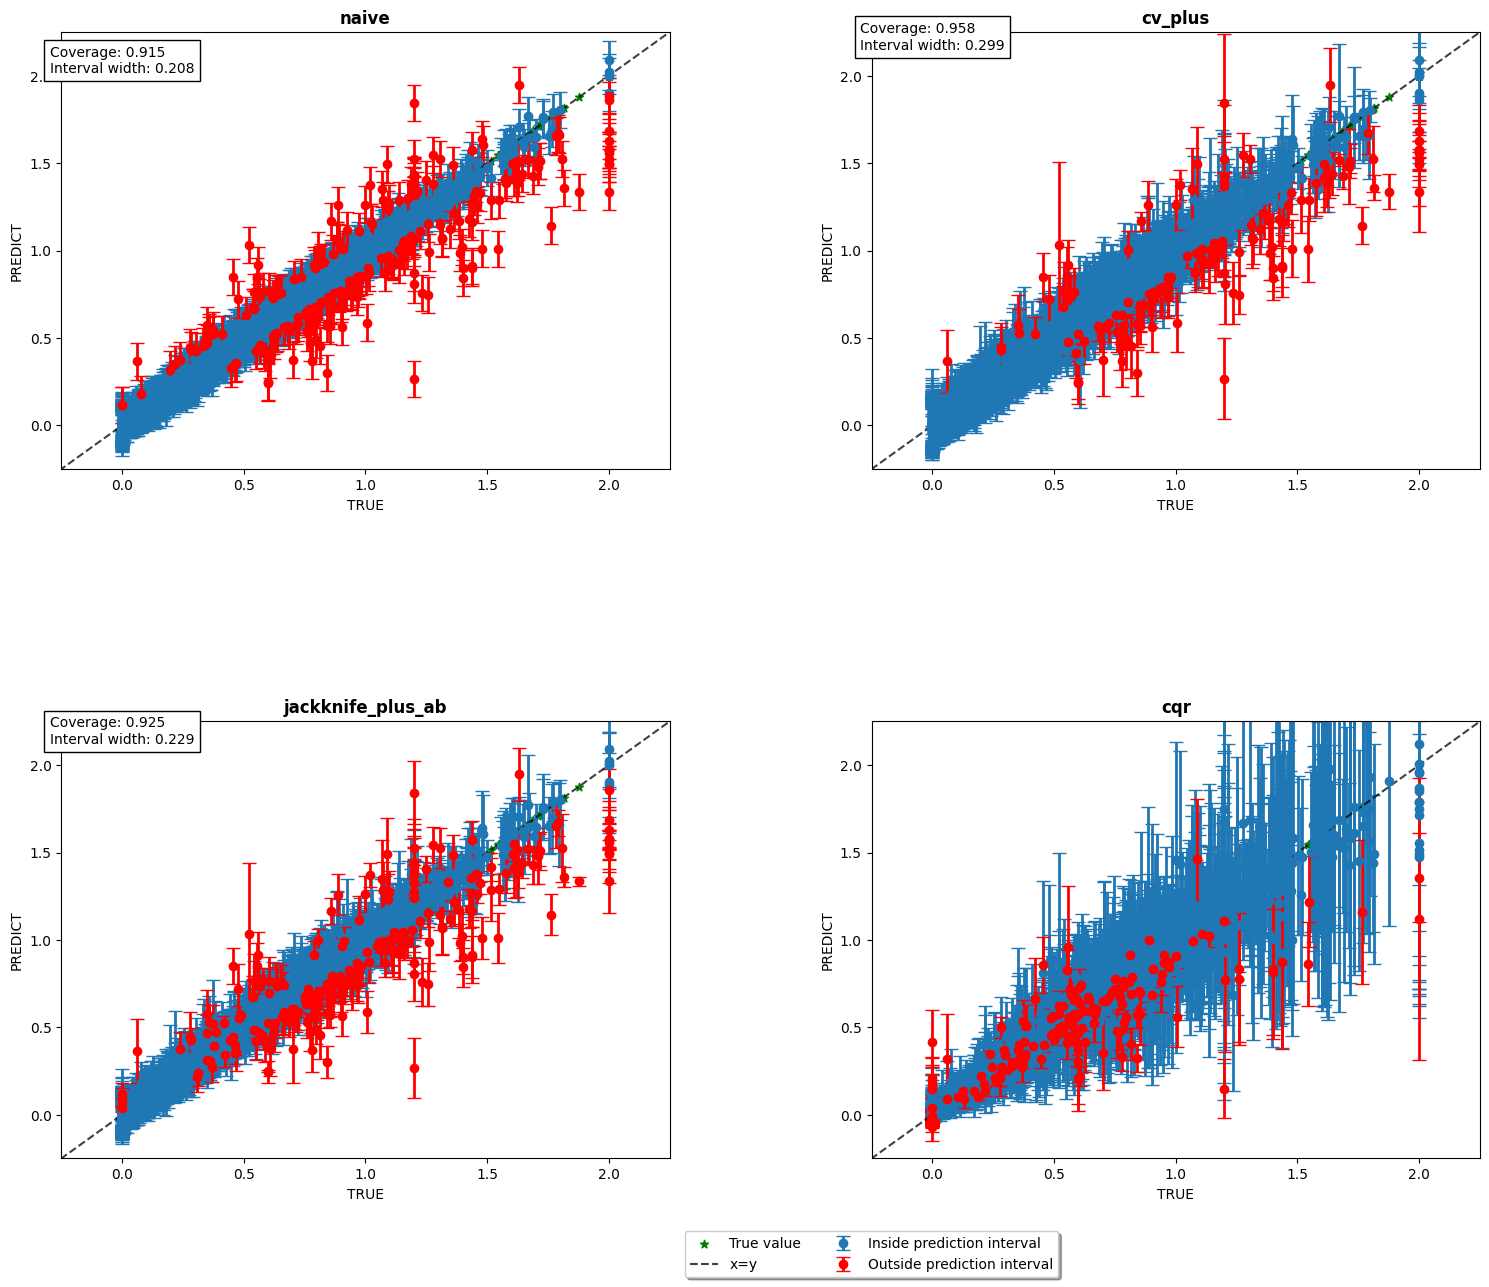

In [16]:
rng = np.random.default_rng(random_state)
round_to = 3
warnings.filterwarnings("ignore")

perc_obs_plot = 1
num_plots = rng.choice(
    len(y_test), int(perc_obs_plot*len(y_test)), replace=False
    )
fig, axs = plt.subplots(2, 2, figsize=(15, 13))
coords = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]

for strategy, coord in zip(STRATEGIES.keys(), coords):
    plot_prediction_intervals(
        strategy,
        coord,
        y_test_sorted[strategy],
        y_pred_sorted[strategy],
        lower_bound[strategy],
        upper_bound[strategy],
        coverage[strategy],
        width[strategy],
        num_plots
    )
    # Bó cố định scale x, y
    coord.set_xlim(-0.25, 2.25)
    coord.set_ylim(-0.25, 2.25)

# Legend dùng chung
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(_, []) for _ in zip(*lines_labels)]
plt.legend(
    lines[:4], labels[:4],
    loc='upper center',
    bbox_to_anchor=(0, -0.15),
    fancybox=True,
    shadow=True,
    ncol=2
)

plt.tight_layout()
plt.show()


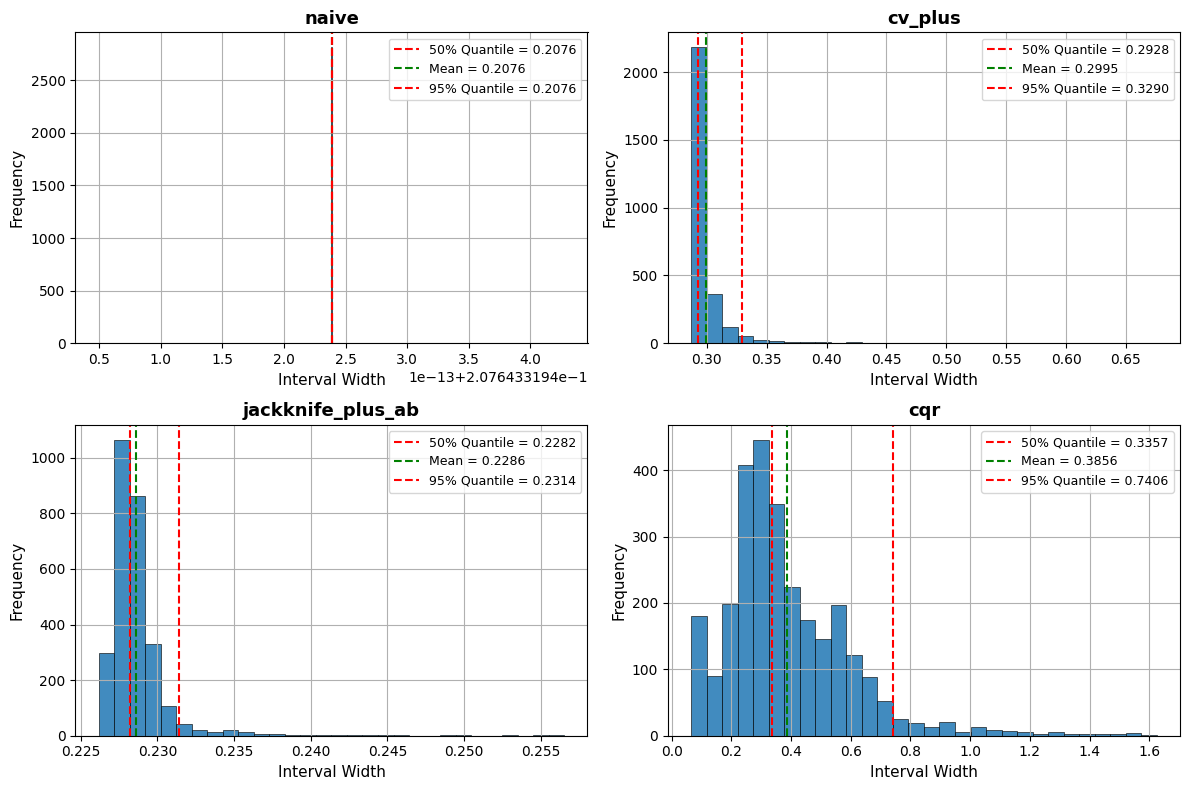

In [17]:
def plot_width_distribution(ax, strat):
    widths = upper_bound[strat] - lower_bound[strat]

    # Thống kê cơ bản
    w1 = np.quantile(widths, 0.5)
    w2 = np.quantile(widths, 0.95)
    w3 = np.mean(widths)
    std_width = np.std(widths)

    # Xử lý bins: nếu std quá nhỏ thì dùng 1 bin duy nhất
    if std_width < 1e-6:
        bins = 1
    else:
        bins = 30

    # Plot histogram
    ax.hist(widths, bins=bins, edgecolor='black', alpha=0.85, linewidth=0.5)

    # Đường kẻ thống kê
    l1 = ax.axvline(w1, color='red', linestyle='--', linewidth=1.5, label=f"50% Quantile = {w1:.4f}")
    l3 = ax.axvline(w3, color='green', linestyle='--', linewidth=1.5, label=f"Mean = {w3:.4f}")
    l2 = ax.axvline(w2, color='red', linestyle='--', linewidth=1.5, label=f"95% Quantile = {w2:.4f}")
    ax.legend(handles=[l1, l3, l2], loc="upper right", fontsize=9)

    # Decor
    ax.set_title(strat, fontsize=13, fontweight='bold')
    ax.set_xlabel("Interval Width", fontsize=11)
    ax.set_ylabel("Frequency", fontsize=11)
    ax.grid(True)
    
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for idx, strat in enumerate(STRATEGIES.keys()):
    plot_width_distribution(axs[idx], strat)

plt.tight_layout()
plt.show()


In [18]:
import pandas as pd

# Tạo list để chứa từng dòng dữ liệu
results = []

# Duyệt qua từng chiến lược đã train
for strat in STRATEGIES.keys():
    # Tính các giá trị cần lưu
    coverage_val = coverage[strat]
    mean_width_val = width[strat]
    
    # Widths từng điểm
    widths = upper_bound[strat] - lower_bound[strat]
    
    w1 = np.quantile(widths, 0.5)   # 50% quantile
    w3 = np.quantile(widths, 0.95)  # 95% quantile
    w2 = np.mean(widths)           # Mean width

    # Append vào danh sách
    results.append({
        "Strategy": strat,
        "Coverage": coverage_val,
        "Mean Width (api)": mean_width_val,
        "Quantile 50%": w1,
        "Mean Width (manual)": w2,
        "Quantile 95%": w3
    })

# Chuyển thành dataframe
df_results = pd.DataFrame(results)

# Tuỳ chỉnh format hiển thị nếu muốn
df_results = df_results.round(4)

# In ra
df_results

,Strategy,Coverage,Mean Width (api),Quantile 50%,Mean Width (manual),Quantile 95%
0,naive,0.9151,0.2076,0.2076,0.2076,0.2076
1,cv_plus,0.9581,0.2995,0.2928,0.2995,0.3290
2,jackknife_plus_ab,0.9254,0.2286,0.2282,0.2286,0.2314
3,cqr,0.9552,0.3856,0.3357,0.3856,0.7406


---
# **FINDING STRAT**
---
### GIỜ MÀ NÓI STRAT NÀO TỐT NHẤT THÌ RẤT KHÓ
### TA RÚT VỀ BÀI TOÁN THEO NHU CẦU KHÁCH HÀNG, GIẢ SỬ MONG MUỐN MEAN WIDTH HOẶC Q 50% WIDTH < MỨC CỤ THỂ
### FIT MAPIE CHO 3 STRAT CHÍNH LÀ NAIVE, PLUS, CQR TẠI MỌI ALPHA TỪ 0 - 0.5 (CHO NHẸ MÁY) ĐỂ TÌM RA COVERAGE CAO NHẤT 


In [19]:
# Cấu hình quantile cần tính
W_Q_1 = 0.5
W_Q_2 = 0.95

w_q_1_label = f"q{int(W_Q_1 * 100)}_width"
w_q_2_label = f"q{int(W_Q_2 * 100)}_width"

alpha_range = np.arange(0.01, 0.51, 0.01)

In [20]:
# --- NAIVE STRATEGY ---
mapie_naive = MapieRegressor(
    estimator=model_2,
    method="naive",
    random_state=42
)
mapie_naive.fit(X_train, y_train)

_, y_pis_naive_all = mapie_naive.predict(X_test, alpha=alpha_range)  # (n_samples, 2, n_alphas)

results_naive = []
for i, alpha in enumerate(alpha_range):
    y_lower_n = y_pis_naive_all[:, 0, i]
    y_upper_n = y_pis_naive_all[:, 1, i]
    widths_n = y_upper_n - y_lower_n

    cov_n = regression_coverage_score(y_test, y_lower_n, y_upper_n)
    mean_w_n = regression_mean_width_score(y_lower_n, y_upper_n)
    q1_n = np.quantile(widths_n, W_Q_1)
    q2_n = np.quantile(widths_n, W_Q_2)

    results_naive.append({
        "alpha": alpha,
        "coverage": cov_n,
        "mean_width": mean_w_n,
        w_q_1_label: q1_n,
        w_q_2_label: q2_n
    })

df_naive_alpha = pd.DataFrame(results_naive)

In [21]:
df_naive_alpha.head(15)

,alpha,coverage,mean_width,q50_width,q95_width
0,0.0100,0.9812,0.5391,0.5391,0.5391
1,0.0200,0.9645,0.3583,0.3583,0.3583
2,0.0300,0.9474,0.2805,0.2805,0.2805
3,0.0400,0.9325,0.2370,0.2370,0.2370
4,0.0500,0.9151,0.2076,0.2076,0.2076
5,0.0600,0.8959,0.1804,0.1804,0.1804
6,0.0700,0.8792,0.1622,0.1622,0.1622
7,0.0800,0.8611,0.1483,0.1483,0.1483
8,0.0900,0.8437,0.1345,0.1345,0.1345
9,0.1000,0.8270,0.1246,0.1246,0.1246


In [22]:
mapie = MapieRegressor(
    estimator=model_2,
    method="plus",
    cv=10,
    random_state=42
)
mapie.fit(X_train, y_train)

_, y_pis_all = mapie.predict(X_test, alpha=alpha_range)
# y_pis_all có shape (n_samples, 2, n_alphas)

results_plus = []
for i, alpha in enumerate(alpha_range):
    y_lower = y_pis_all[:, 0, i]
    y_upper = y_pis_all[:, 1, i]
    widths = y_upper - y_lower

    cov = regression_coverage_score(y_test, y_lower, y_upper)
    mean_w = regression_mean_width_score(y_lower, y_upper)
    q1 = np.quantile(widths, W_Q_1)
    q2 = np.quantile(widths, W_Q_2)

    results_plus.append({
        "alpha": alpha,
        "coverage": cov,
        "mean_width": mean_w,
        w_q_1_label: q1,
        w_q_2_label: q2
    })

df_plus_alpha = pd.DataFrame(results_plus)


In [23]:
df_plus_alpha.head(30)

,alpha,coverage,mean_width,q50_width,q95_width
0,0.0100,0.9904,0.6999,0.6981,0.7179
1,0.0200,0.9819,0.4900,0.4857,0.5104
2,0.0300,0.9734,0.3905,0.3844,0.4198
3,0.0400,0.9652,0.3370,0.3310,0.3647
4,0.0500,0.9581,0.2995,0.2928,0.3290
5,0.0600,0.9524,0.2701,0.2631,0.3021
6,0.0700,0.9485,0.2464,0.2389,0.2818
7,0.0800,0.9435,0.2273,0.2193,0.2655
8,0.0900,0.9350,0.2114,0.2027,0.2517
9,0.1000,0.9293,0.1981,0.1889,0.2410


In [24]:
# -------------------------------
# Phần CQR: Fit nhiều lần theo alpha (vì phải truyền alpha ngay lúc khởi tạo model)
# -------------------------------
results_cqr = []

for alpha in alpha_range:
    mapie_cqr = MapieQuantileRegressor(
        estimator=model_2,
        method="quantile",
        cv="split",
        alpha=alpha
    )
    mapie_cqr.fit(X_train, y_train, calib_size=0.3, random_state=42)
    _, y_pis_cqr = mapie_cqr.predict(X_test)

    y_lower_cqr = y_pis_cqr[:, 0, 0]
    y_upper_cqr = y_pis_cqr[:, 1, 0]
    widths_cqr = y_upper_cqr - y_lower_cqr

    cov_cqr = regression_coverage_score(y_test, y_lower_cqr, y_upper_cqr)
    mean_w_cqr = regression_mean_width_score(y_lower_cqr, y_upper_cqr)
    q1_cqr = np.quantile(widths_cqr, W_Q_1)
    q2_cqr = np.quantile(widths_cqr, W_Q_2)

    results_cqr.append({
        "alpha": alpha,
        "coverage": cov_cqr,
        "mean_width": mean_w_cqr,
        w_q_1_label: q1_cqr,
        w_q_2_label: q2_cqr
    })

df_cqr_alpha = pd.DataFrame(results_cqr)

INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-

In [25]:
df_cqr_alpha.head(30)

,alpha,coverage,mean_width,q50_width,q95_width
0,0.0100,0.9915,0.8433,0.7798,1.3099
1,0.0200,0.9819,0.6068,0.5648,1.0271
2,0.0300,0.9723,0.5026,0.4511,0.9274
3,0.0400,0.9659,0.4205,0.3724,0.8133
4,0.0500,0.9552,0.3856,0.3357,0.7406
5,0.0600,0.9428,0.3452,0.3060,0.6977
6,0.0700,0.9403,0.3219,0.2799,0.6450
7,0.0800,0.9261,0.2933,0.2507,0.6214
8,0.0900,0.9119,0.2704,0.2320,0.5869
9,0.1000,0.9055,0.2557,0.2161,0.5717


---
# NHẬN XÉT
### VỀ COVERAGE: TẠI MỌI MỨC ALPHA THÌ THEO THỨ TỰ "NAIVE, PLUS, CQR" TA THẤY TÍNH CHẤT COVERAGE KHÁ ĐẶC BIỆT TƯƠNG ỨNG LÀ "HỤT, THỪA, CHUẨN XẤP XỈ" SO VỚI ĐỘ TIN CẬY MONG MUỐN 
### TUY NHIÊN BẢN CHẤT VẪN CHỈ LÀ SỰ ĐÁNH ĐỔI WIDTH (DO THUẬT TOÁN KHÁC NHAU) THEO THỨ TỰ: 
- ### NAIVE: CỨNG, HẸP, CHẮC CHẮN HỤT
- ### PLUS: HƠI HƠI LINH HOẠT (NHIỀU TRƯỜNG HỢP VỪA, RỘNG)
- ### CQR: LINH HOẠT CAO (CÂN BẰNG NHẤT, CÓ HẸP QUÁ VÀ CŨNG CÓ RỘNG QUÁ)"
---
### BƯỚC TIẾP THEO LÀ CHỌN RA STRAT PHÙ HỢP NHẤT VỚI MONG MUỐN KHÁCH HÀNG
- ### WIDTH MAX ACCEPT: LÀ SAI SỐ 1 PHÍA MONG MUỐN / ĐƯỢC CHO PHÉP
- ### METRIC CHOIE: ĐỂ NẾU MUỐN THAY THÀNH MEAN HAY Q50 HAY Q95 THÌ CHỈNH CHO NHANH
---

In [26]:
# ---- STEP 1: Đặt ngưỡng sai số tối đa (theo bài toán KPI) ----
width_max_acceptable = 0.1       # Đổi tùy bài toán
metric_choice = "q50_width"       # Đổi tùy bài toán "mean_width" hoặc "q95_width"

# ---- STEP 2: Duyệt qua 3 DataFrame để chọn dòng tốt nhất với ngưỡng đã cho ----
df_dict = {
    "naive": df_naive_alpha,
    "cv_plus": df_plus_alpha,
    "cqr": df_cqr_alpha
}

selected_rows = []

for name, df in df_dict.items():
    best_row = df.iloc[(df[metric_choice] - width_max_acceptable).abs().argmin()]
    best_row_dict = best_row.to_dict()
    best_row_dict["strategy"] = name
    selected_rows.append(best_row_dict)

# ---- STEP 3: Tổng hợp lại thành bảng kết quả ----
df_selected = pd.DataFrame(selected_rows)[["strategy", "alpha", "coverage", "mean_width", "q50_width", "q95_width"]]

def highlight_metric_and_best_coverage(df, metric_choice):
    def highlight_cells(val):
        return 'font-weight: bold; background-color: #3CB371' if val == df["coverage"].max() else ''
    
    styles = df.style.applymap(highlight_cells, subset=["coverage"])
    styles = styles.set_table_styles([
        {'selector': f'th.col{df.columns.get_loc(metric_choice)}',
         'props': [('background-color', '#4682B4')]}
    ])
    return styles

# Hiển thị bảng đẹp
display(highlight_metric_and_best_coverage(df_selected, metric_choice))

# ---- STEP 4: In kết luận bằng ngôn ngữ tự nhiên ----
best_strategy = df_selected.loc[df_selected["coverage"].idxmax()]
print("🔎 KẾT LUẬN")
print(f"➡️ Với cách chọn max width acceptable = {width_max_acceptable} theo hệ metric '{metric_choice}'")
print(f"✅ Chiến lược tốt nhất là **{best_strategy['strategy']}** với coverage đạt **{best_strategy['coverage']:.4f}**.")

,strategy,alpha,coverage,mean_width,q50_width,q95_width
0,naive,0.140000,0.773357,0.098471,0.098471,0.098471
1,cv_plus,0.250000,0.843694,0.107815,0.099913,0.150867
2,cqr,0.250000,0.755950,0.132024,0.098349,0.378219


🔎 KẾT LUẬN
➡️ Với cách chọn max width acceptable = 0.1 theo hệ metric 'q50_width'
✅ Chiến lược tốt nhất là **cv_plus** với coverage đạt **0.8437**.


In [27]:
# STEP 5: Fit lại 3 mô hình theo alpha đã chọn
refit_preds = {}
refit_intervals = {}

for _, row in df_selected.iterrows():
    strat = row["strategy"]
    alpha = row["alpha"]

    if strat == "cqr":
        model = MapieQuantileRegressor(
            estimator=model_2,
            method="quantile",
            cv="split",
            alpha=alpha
        )
        model.fit(X_train, y_train, calib_size=0.3, random_state=42)
        y_pred, y_pis = model.predict(X_test)
    else:
        model = MapieRegressor(
            estimator=model_2,
            method=strat if strat == "naive" else "plus",
            cv=10 if strat == "cv_plus" else None,
            test_size=0.3,
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred, y_pis = model.predict(X_test, alpha=alpha)

    refit_preds[strat] = y_pred
    refit_intervals[strat] = y_pis
    
refit_y_test_sorted = {}
refit_y_pred_sorted = {}
refit_lower_bound = {}
refit_upper_bound = {}
refit_coverage = {}
refit_width = {}

for strat in refit_preds:
    y_pred = refit_preds[strat]
    y_pis = refit_intervals[strat]

    y_lower = y_pis[:, 0, 0]
    y_upper = y_pis[:, 1, 0]

    y_test_sorted_, y_pred_sorted_, y_lower_, y_upper_ = sort_y_values(y_test, y_pred, y_pis)

    refit_y_test_sorted[strat] = y_test_sorted_
    refit_y_pred_sorted[strat] = y_pred_sorted_
    refit_lower_bound[strat] = y_lower_
    refit_upper_bound[strat] = y_upper_
    refit_coverage[strat] = regression_coverage_score(y_test, y_lower, y_upper)
    refit_width[strat] = regression_mean_width_score(y_lower, y_upper)

INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.


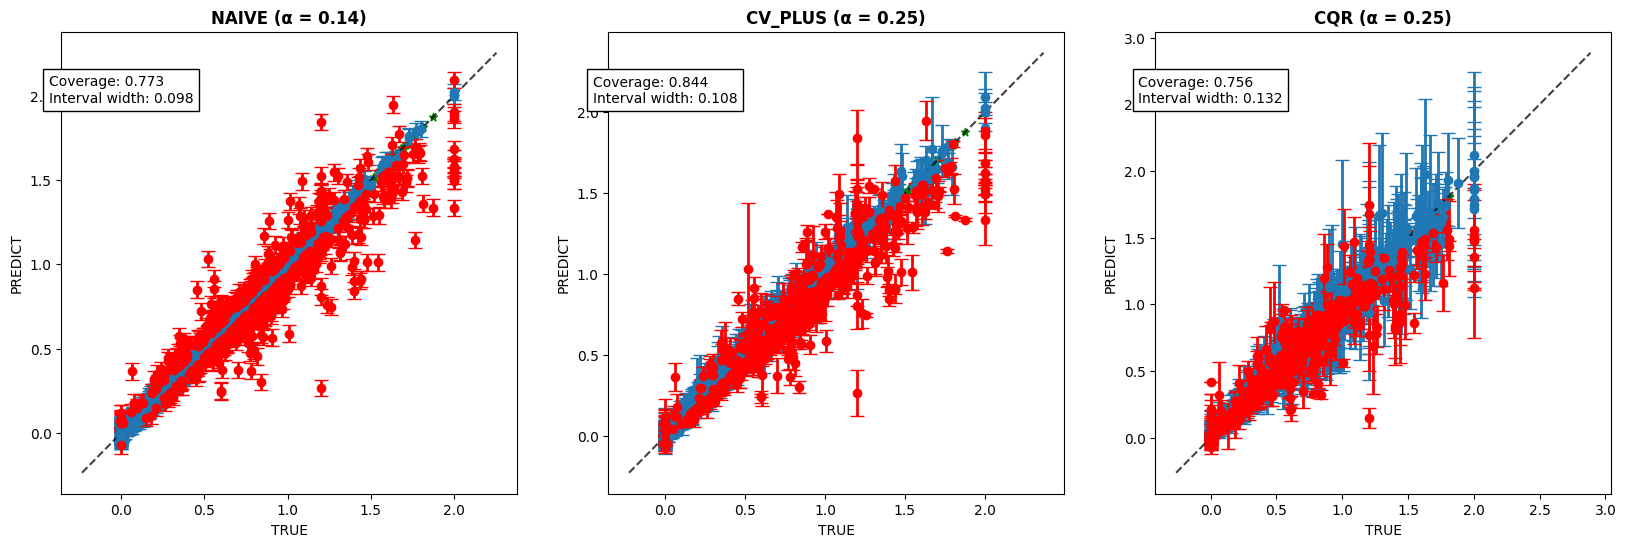

In [28]:
rng = np.random.default_rng(random_state)
round_to = 3
warnings.filterwarnings("ignore")

perc_obs_plot = 1
num_plots = rng.choice(len(y_test), int(perc_obs_plot * len(y_test)), replace=False)

# 1 row x 3 cols = 3 plot (vì mình chỉ giữ lại 3 strat)
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

for idx, (strat, ax) in enumerate(zip(refit_preds.keys(), axs)):
    plot_prediction_intervals(
        title=f"{strat.upper()} (α = {df_selected.loc[df_selected['strategy'] == strat, 'alpha'].values[0]:.2f})",
        axs=ax,
        y_test_sorted=refit_y_test_sorted[strat],
        y_pred_sorted=refit_y_pred_sorted[strat],
        lower_bound=refit_lower_bound[strat],
        upper_bound=refit_upper_bound[strat],
        coverage=refit_coverage[strat],
        width=refit_width[strat],
        num_plots_idx=num_plots
    )

plt.show()

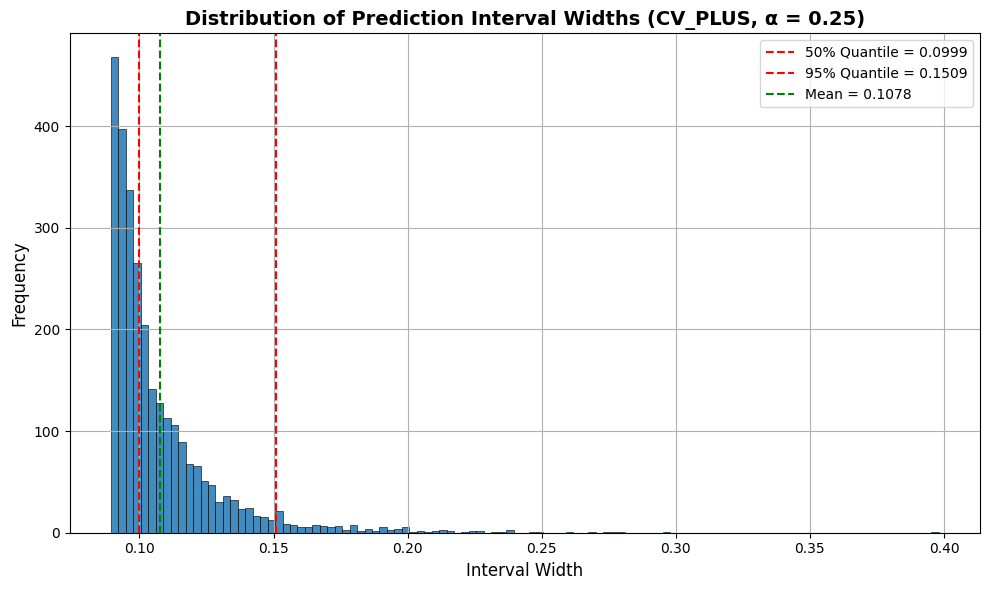

In [29]:
# Lấy lại thông tin chiến lược tốt nhất
best_strat = best_strategy["strategy"]
best_alpha = best_strategy["alpha"]

# Truy cập dữ liệu refit đã được tính từ trước
y_lower_best = refit_lower_bound[best_strat]
y_upper_best = refit_upper_bound[best_strat]
widths_best = y_upper_best - y_lower_best

# Tính các thống kê mô tả
w1 = np.quantile(widths_best, 0.5)
w2 = np.quantile(widths_best, 0.95)
w3 = np.mean(widths_best)

# Vẽ histogram
plt.figure(figsize=(10, 6))
plt.hist(widths_best, bins="auto", edgecolor='black', alpha=0.85, linewidth=0.5)

# Các đường tham chiếu
plt.axvline(w1, color='red', linestyle='--', linewidth=1.5, label=f"50% Quantile = {w1:.4f}")
plt.axvline(w2, color='red', linestyle='--', linewidth=1.5, label=f"95% Quantile = {w2:.4f}")
plt.axvline(w3, color='green', linestyle='--', linewidth=1.5, label=f"Mean = {w3:.4f}")

# Tiêu đề và chú thích
plt.title(f"Distribution of Prediction Interval Widths ({best_strat.upper()}, α = {best_alpha:.2f})", fontsize=14, fontweight='bold')
plt.xlabel("Interval Width", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(loc="upper right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()